<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br><br><br>

# Listed Volatility and Variance Derivatives

**Wiley Finance (2017)**

Dr. Yves J. Hilpisch | The Python Quants GmbH

http://tpq.io | [@dyjh](http://twitter.com/dyjh) | http://books.tpq.io

<img src="https://hilpisch.com/images/lvvd_cover.png" alt="Listed Volatility and Variance Derivatives" width="30%" align="left" border="0">

# VSTOXX Index

## Introduction

This chapter is about the (re-) calculation of the VSTOXX index, the volatility index based on EURO STOXX 50 index options. The goal is to achieve a good understanding of the processes and underlying mechanics of calculating the VSTOXX index. You will find all background information as well as Python code that will enable you to recalculate historical VSTOXX index values as well as current ones in (almost) real-time. The chapter about the _Model-Free Replication of Variance_ provides the theoretical background for the concepts presented in this chapter.

The (main) VSTOXX index itself is based on two sub-indexes, which themselves are derived from Eurex option series for both European puts and calls on the EURO STOXX 50 index. The algorithm, and therefore this chapter as well, is comprised of three main parts:

* collect and clean-up the data of the necessary option series
* compute the sub-indexes from the option data
* compute the VSTOXX index from the relevant sub-indexes

A few remarks about the option series and sub-indexes used and their expiry dates and time horizons, respectively, seem in order. There are eight sub-indexes of the VSTOXX which each measure the implied volatility of an option series with fixed expiry. For example, the VSTOXX 1M sub-index starts with the option series that has one month expiry and is calculated up to two days prior to the fixed maturity date of the according option series. The VSTOXX index measures the implied volatility of an "imaginary" options series with a fixed time to expiry of 30 days. This is achieved through linear interpolation of the two nearest sub-indexes, generally VSTOXX 1M and VSTOXX 2M. On the two days before VSTOXX 1M expiry, the VSTOXX 2M and VSTOXX 3M are used instead and an extrapolation takes place.

The following table lists all the sub-indexes and provides additional information.

    ============ ======= ============== ===========================================
     Sub-index    Code    ISIN           Settlement date of the option series used
    ============ ======= ============== ===========================================
     VSTOXX 1M    V6I1    DE000A0G87B2   The last available within 1 month
     VSTOXX 2M    V6I2    DE000A0G87C0   The last available within 2 months
     VSTOXX 3M    V6I3    DE000A0G87D8   The last available within 3 months
     VSTOXX 6M    V6I4    DE000A0G87E6   The last available within 6 months
     VSTOXX 9M    V6I5    DE000A0G87F3   The last available within 9 months
     VSTOXX 12M   V6I6    DE000A0G87G1   The last available within 12 months
     VSTOXX 18M   V6I7    DE000A0G87H9   The last available within 18 months
     VSTOXX 24M   V6I8    DE000A0G87J5   The last available within 24 months
    ============ ======= ============== ===========================================

## Collecting Option Data

As pointed out, the VSTOXX is based on two sub-indexes, generally the VSTOXX 1M and VSTOXX 2M, sometimes VSTOXX 2M and VSTOXX 3M. The sub-indexes themselves are based on the option series on the EURO STOXX 50 index with respective time to expiry. We therefore need the prices of all options with maturities up to 3 months. We use historical data as provided by Eurex itself as the data source. See the web site http://bit.ly/1GY5KCI.

The code to collect the data can be found in the module ``index_collect_option_data.py`` (see appendix for the complete script). Like usual, the module starts with some imports and parameter definitions.

In [1]:
!sed -n 11,24p scripts/index_collect_option_data.py

import requests
from io import *
import numpy as np
import pandas as pd
import datetime as dt
from bs4 import BeautifulSoup
from index_date_functions import *

#
# The URL template
#
URL = 'https://www.eurex.com/ex-en/data/statistics/market-statistics-online/'
URL += '100!onlineStats?productGroupId=13370&productId=69660&viewType=3&'
URL += 'cp=%s&month=%s&year=%s&busDate=%s'


In addition, the module contains six functions. The first is ``collect_option_series()``:

In [2]:
import sys; sys.path.append('./scripts/')

In [3]:
import index_collect_option_data as icod

In [4]:
icod.collect_option_series??

Signature: icod.collect_option_series(month, year, start)
Source:   
def collect_option_series(month, year, start):
    ''' Collects daily option data from web source.

    Parameters
    month: int
        maturity month
    year: int
        maturity year
    start: datetime object
        starting date

    Returns
    dataset: pandas DataFrame object
        object containing the collected data
    '''
    end = dt.datetime.today()
    delta = (end - start).days

    dataset = pd.DataFrame()
    for t in range(0, delta):  # runs from start to today
        date = start + dt.timedelta(t)
        dummy = get_data(month, year, date)  # get data for one day
        if len(dummy) != 0:
            if len(dataset) == 0:
                dataset = dummy
            else:
                dataset = pd.concat((dataset, dummy))  # add data

    return dataset
File:      ~/Dropbox/Program/cert/21_lvvd/live/scripts/index_collect_option_data.py
Type:      function


This function collects the data of the option series with maturity in the month ``month`` and year ``year``. It is called by the ``function start_collecting()`` and calls the ``function get_data()`` for every single day from the date ``start`` to today. It returns a complete set of prices (both puts and calls) for that series.

The second function is ``get_data()``.

In [5]:
icod.get_data??

Signature: icod.get_data(month, year, date)
Source:   
def get_data(month, year, date):
    ''' Get the data for an option series.

    Parameters
    month: int
        maturity month
    year: int
        maturity year
    date: datetime object
        the date for which the data is collected

    Returns
    dataset: pandas DataFrame object
        object containing call & put option data
    '''

    date_string = date.strftime('%Y%m%d')
    # loads the call data from the web
    data = get_data_from_www('Call', month, year, date_string)
    calls = parse_data(data, date)  # parse the raw data
    calls = calls.rename(columns={'Daily settlem. price': 'Call_Price'})

    calls = pd.DataFrame(calls.pop('Call_Price').astype(float))
    # the same for puts
    data = get_data_from_www('Put', month, year, date_string)
    puts = parse_data(data, date)
    puts = puts.rename(columns={'Daily settlem. price': 'Put_Price'})
    puts = pd.DataFrame(puts.pop('Put_Price').astype(float))

    d

This one is called by the function ``collect_option_series()`` and calls itself the functions ``get_data_from_www()``, ``parse_data(data, date)`` and ``merge_and_filter()``. It returns the prices of the option series with expiry date in month ``month`` and year ``year`` for the day ``date``.

The third function is ``get_data_from_www()``.

In [6]:
icod.get_data_from_www??

Signature: icod.get_data_from_www(oType, matMonth, matYear, date)
Source:   
def get_data_from_www(oType, matMonth, matYear, date):
    ''' Retrieves the raw data of an option series from the web.

    Parameters
    oType: string
        either 'Put' or 'Call'
    matMonth: int
        maturity month
    matYear: int
        maturity year
    date: string
        expiry in the format 'YYYYMMDD'

    Returns
    a: string
        raw text with option data
    '''

    url = URL % (oType, matMonth, matYear, date)  # parametrizes the URL
    a = requests.get(url).text
    return a
File:      ~/Dropbox/Program/cert/21_lvvd/live/scripts/index_collect_option_data.py
Type:      function


The function collects the prices of an option series for a single day (defined by ``date``) from the web. The option series is defined by the date of its expiry, given by ``matMonth`` and ``matYear``, the type of the options is given by ``oType`` which can be either ``Put`` or ``Call``. It returns a complete HTML file.

``merge_and_filter()`` is the fourth function.

In [7]:
icod.merge_and_filter??

Signature: icod.merge_and_filter(puts, calls)
Source:   
def merge_and_filter(puts, calls):
    ''' Gets two pandas time series for the puts and calls
    (from the same option series), merges them, filters out
    all options with prices smaller than 0.5 and
    returns the resulting DataFrame object.

    Parameters
    puts: pandas DataFrame object
        put option data
    calls: pandas DataFrame object
        call option data

    Returns
    df: pandas DataFrame object
        merged & filtered options data
    '''

    df = calls.join(puts, how='inner')  # merges the two time series
    # filters all prices which are too small
    df = df[(df.Put_Price >= 0.5) & (df.Call_Price >= 0.5)]

    return df
File:      ~/Dropbox/Program/cert/21_lvvd/live/scripts/index_collect_option_data.py
Type:      function


This one gets two time series ``puts`` and ``calls`` (typically of the same option series), merges them, filters out all options with prices below 0.5 and returns the resulting pandas ``DataFrame`` object.

``parse_data()`` is the fifth function.

In [8]:
icod.parse_data??

Signature: icod.parse_data(data, date)
Source:   
def parse_data(data, date):
    ''' Parses the HTML table and transforms it into a CSV compatible
    format. The result can be directly imported into a pandas DataFrame.

    Parameters
    data: string
        document containing the Web content
    date: datetime object
        date for which the data is parsed

    Returns
    dataset: pandas DataFrame object
        transformed option raw data
    '''
    
    data_list = list()
    date_value = dt.date(date.year, date.month, date.day)
    soup = BeautifulSoup(data, 'html.parser')
    
    tables = soup.select('table.dataTable')
    if len(tables) != 1:
        raise ValueError('table selector is not unique')
    else:
        table = tables[0]
    columns = ['Pricing day',] + [cell.get_text() for cell in table.find_all('th')]
        
    for line in table.find_all('tr')[:-1]:
        data_list.append([date_value,]+[float(cell.get_text().replace(',','')) for cell in line.find_all(

It gets the string ``data`` which contains the HTML text delivered by function ``get_data_from_www()``, parses that string to a pandas ``DataFrame`` object with double index ``date`` and ``strike price`` and returns that object.

The sixth and final function is ``data_collection()``.

In [9]:
icod.data_collection??

Signature: icod.data_collection(path='')
Source:   
def data_collection(path=''):
    ''' Main function which saves data into the HDF5 file
    'index_option_series.h5' for later use.

    Parameters
    path: string
        path to store the data
    '''
    # file to store data
    store = pd.HDFStore(path + 'index_option_series.h5', 'a')

    today = dt.datetime.today()
    start = today - dt.timedelta(31)  # the last 31 days

    day = start.day
    month = start.month
    year = start.year

    for i in range(4):  # iterates over the next 4 months
        dummy_month = month + i
        dummy_year = year
        if dummy_month > 12:
            dummy_month -= 12
            dummy_year += 1

        # collect daily data beginning 31 days ago (start) for
        # option series with expiry dummy_month, dummy_year
        dataset = collect_option_series(dummy_month, dummy_year, start)

        dummy_date = dt.datetime(dummy_year, dummy_month, day)

        # abbreviation for expiry d

This function is to initiate and finalize the collection of all relevant option series data sets. It saves the resulting data in a file named ``index_option_series.h5``.

In [10]:
path = './data/'

Let us collect option data since all other steps depend on this data. We import the module as ``icod``.

In [11]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings; warnings.simplefilter('ignore')

Next, fix a target day relative to today such that you hit a business day for which closing data is available.

In [12]:
today = dt.datetime.now()
## make sure to hit a business day
target_day = today - dt.timedelta(days=2)
ds = target_day.strftime('%Y%m%d')
ds

'20201111'

In [13]:
URL = 'https://www.eurex.com/ex-en/data/statistics/market-statistics-online/'
URL += '100!onlineStats?productGroupId=13370&productId=69660&viewType=3&'
URL += 'cp=%s&month=%s&year=%s&busDate=%s'
URL % ('Call', 12, 2020, '20201111')

'https://www.eurex.com/ex-en/data/statistics/market-statistics-online/100!onlineStats?productGroupId=13370&productId=69660&viewType=3&cp=Call&month=12&year=2020&busDate=20201111'

Then, for example, collect option data for puts and calls with a maturity as defined by the parameters as follows.

In [14]:
## adjust maturity parameters if necessary
call_data = icod.get_data_from_www(oType='Call', matMonth=12,
                                   matYear=2020, date=ds)
put_data = icod.get_data_from_www(oType='Put', matMonth=12,
                                  matYear=2020, date=ds)

The return objects need to be parsed.

In [15]:
## parse the raw data
calls = icod.parse_data(call_data, target_day)
puts = icod.parse_data(put_data, target_day)

Let us have a look at some meta information about the call options data.

In [16]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 159 entries, (Timestamp('2020-11-11 00:00:00'), 100.0) to (Timestamp('2020-11-11 00:00:00'), 10000.0)
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Version number        159 non-null    float64
 1   Opening price         159 non-null    float64
 2   Daily high            159 non-null    float64
 3   Daily low             159 non-null    float64
 4   Last price            159 non-null    float64
 5   Daily settlem. price  159 non-null    float64
 6   Traded contracts      159 non-null    float64
 7   Open interest         159 non-null    float64
 8   Open interest (adj.)  159 non-null    float64
dtypes: float64(9)
memory usage: 13.0 KB


In [17]:
calls.head()

Version number  Opening price  Daily high  \
Pricing day Strike price                                              
2020-11-11  100.0                    0.0            0.0         0.0   
            200.0                    0.0            0.0         0.0   
            300.0                    0.0            0.0         0.0   
            400.0                    0.0            0.0         0.0   
            500.0                    0.0            0.0         0.0   

                          Daily low  Last price  Daily settlem. price  \
Pricing day Strike price                                                
2020-11-11  100.0               0.0         0.0                3370.4   
            200.0               0.0         0.0                3270.3   
            300.0               0.0         0.0                3170.3   
            400.0               0.0         0.0                3070.2   
            500.0               0.0         0.0                2970.1   

                          Traded contracts  Open interest  \
Pricing day Strike price                                    
2020-11-11  100.0                     47.0         3217.0   
            200.0                      0.0            0.0   
            300.0                      0.0            0.0   
            400.0                      0.0            0.0   
            500.0                    161.0        11061.0   

                          Open interest (adj.)  
Pricing day Strike price                        
2020-11-11  100.0                       3235.0  
            200.0                          0.0  
            300.0                          0.0  
            400.0                          0.0  
            500.0                      10902.0

And about the put options data.

In [18]:
puts.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 159 entries, (Timestamp('2020-11-11 00:00:00'), 100.0) to (Timestamp('2020-11-11 00:00:00'), 10000.0)
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Version number        159 non-null    float64
 1   Opening price         159 non-null    float64
 2   Daily high            159 non-null    float64
 3   Daily low             159 non-null    float64
 4   Last price            159 non-null    float64
 5   Daily settlem. price  159 non-null    float64
 6   Traded contracts      159 non-null    float64
 7   Open interest         159 non-null    float64
 8   Open interest (adj.)  159 non-null    float64
dtypes: float64(9)
memory usage: 13.0 KB


In a next step, we take out the daily settlement prices for both the puts and calls and define two new ``DataFrame`` objects.

In [19]:
calls = pd.DataFrame(calls.rename(
        columns={'Daily settlem. price': 'Call_Price'}
                            ).pop('Call_Price').astype(float))

In [20]:
puts = pd.DataFrame(puts.rename(
        columns={'Daily settlem. price': 'Put_Price'}
                            ).pop('Put_Price').astype(float))

These two get then merged via the function ``merge_and_filter()`` into another new ``DataFrame`` object.

In [21]:
dataset = icod.merge_and_filter(puts, calls)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 81 entries, (Timestamp('2020-11-11 00:00:00'), 2150.0) to (Timestamp('2020-11-11 00:00:00'), 4150.0)
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Call_Price  81 non-null     float64
 1   Put_Price   81 non-null     float64
dtypes: float64(2)
memory usage: 2.9 KB


This whole procedure is implemented in the function ``collect_option_series()`` which yields the same result.

In [22]:
os = icod.collect_option_series(12, 2020, target_day)
os.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 160 entries, (Timestamp('2020-11-11 00:00:00'), 2150.0) to (Timestamp('2020-11-12 00:00:00'), 4075.0)
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Call_Price  160 non-null    float64
 1   Put_Price   160 non-null    float64
dtypes: float64(2)
memory usage: 3.6 KB


The function ``data_collection()`` repeats this procedure for all those dates for which option data is available and writes (appends) the results in a HDF5 database file.

In [23]:
# uncomment to initiate the process (takes a while)
%time icod.data_collection(path)

CPU times: user 42.8 s, sys: 513 ms, total: 43.3 s
Wall time: 2min 7s


For the further analyses, we open this HDF5 database file.

In [24]:
store = pd.HDFStore(path + 'index_option_series.h5', 'r')
store

<class 'pandas.io.pytables.HDFStore'>
File path: ./data/index_option_series.h5

The collected option series data is easily read from the HDF5 database file in monthly chunks.

In [25]:
Dec20 = store['Dec20']
Dec20.info()
store.close()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1786 entries, (Timestamp('2020-10-16 00:00:00'), 1700.0) to (Timestamp('2020-11-12 00:00:00'), 4075.0)
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Call_Price  1786 non-null   float64
 1   Put_Price   1786 non-null   float64
dtypes: float64(2)
memory usage: 38.2 KB


Some selected option prices from the large data set:

In [26]:
Dec20.iloc[25:35]

Call_Price  Put_Price
Pricing day Strike price                       
2020-10-16  2325.0             922.3        5.3
            2350.0             897.8        5.7
            2375.0             873.2        6.2
            2400.0             848.7        6.8
            2425.0             824.3        7.3
            2450.0             799.9        8.0
            2475.0             775.5        8.6
            2500.0             751.2        9.4
            2525.0             727.0       10.2
            2550.0             702.8       11.0

## Calculating the Sub-Indexes

In this section, we use the data file created in the previous one. For all dates of the data file, the Python module ``index_subindex_calculation.py`` (see the appendix for the complete script) used in this section decides whether the VSTOXX 1M sub-index is defined or not (remember that the sub-index is not defined at the final settlement day and one day before). If it is defined, the script computes the value of the sub-indexes VSTOXX 1M and VSTOXX 2M; if not, it computes the values of the sub-indexes VSTOXX 2M and VSTOXX 3M, respectively. Finally, it returns a pandas ``DataFrame`` object with the three time series.

### The Algorithm

First, we focus on the computation of the value of a single sub-index for a given date. Given are the prices $C_i, i \in \{0,...,n\},$ of a series of  European call options on the EURO STOXX 50 with fixed maturity date $T$ and exercise prices $K_i, i \in \{0,...,n\},$ as well as the prices $P_i, i \in \{0,...,n\},$ of a series of European put options on EURO STOXX 50 with the same maturity date $T$ and exercise prices $K_i$. Let further hold $K_i < K_{i+1}$ for all $i \in \{0,....,n-1\}$.

Then, the value of the relevant sub-index $V$ is as follows (see also the chapter about _Model-Free Replication of Variance_):

$$
V = 100 \cdot \sqrt{\hat{\sigma}^2}
$$

with

$$
\hat{\sigma}^2 = \frac{2}{T} \sum_{i=0}^n \frac{\Delta K_i}{{K_i}^2} \mathrm{e}^{rT} M_i - \frac{1}{T}\left( \frac{F}{K_*}-1\right)^2
$$

where

$$
\begin{array}{ll}
 \Delta K_i &=\left\{ \begin{array}{ll} K_1-K_0 & \mbox{for } i=0 \\  \dfrac{K_{i+1}-K_{i-1}}{2} &  \mbox{for } i = 1,...,n-1 \\   K_n-K_{n-1} & \mbox{for } i=n \end{array} \right. \\  \\
 r          &=  \mbox{constant risk-free short rate appropriate for maturity $T$} \\ \\
 F 	    &= K_j+ \mathrm{e}^{rT}|C_j-P_j|, \mbox{ where } j=\displaystyle \min_{i \in \{0,...,n\}}\{|C_i-P_i|\} \\ \\
 K_*        &= \displaystyle \max_{ K_{i | i \in \{0,...,n\}}} \{K_i < F \}, \\ \\
 M_i        & =    \left\{ \begin{array}{ll} P_i & \mbox{for } K_i<K_* \\  \dfrac{P_i-C_i}{2} &  \mbox{for } K_i=K_*\\   C_i & \mbox{for } K_i>K_* \end{array} \right.
\end{array}
$$

We implement a function to compute one value of a single sub-index. Thereafter, we extend that function to compute time series for both VSTOXX 1M and VSTOXX 2M indexes as well as parts of the VSTOXX 3M index. Imports again make up the beginning of the script.

In [27]:
!sed -n 10,15p scripts/index_subindex_calculation.py

import math
import numpy as np
import pandas as pd
import datetime as dt
import index_date_functions as idf
pd.options.mode.chained_assignment = None


A core function of the script is ``compute_subindex()``.

In [28]:
import index_subindex_calculation as isc

In [29]:
isc.compute_subindex??

Signature: isc.compute_subindex(data, delta_T, R)
Source:   
def compute_subindex(data, delta_T, R):
    ''' Computes a sub-index for given option series data.

    Parameters
    data: pandas.DataFrame object
        contains the option data
    delta_T: float
        time interval
    R: float
        discount factor

    Returns
    subVSTOXX: float
        sub-index value
    '''
    # difference between put and call option with same strike
    data['Diff_Put_Call'] = np.abs(data.Put_Price - data.Call_Price)
    # converts the strike price which serves as index so far
    # to a regular data column
    data = data.reset_index()
    data['delta_K'] = None
    # differences between the different strikes of the series
    data['delta_K'].iloc[1:-1] = [(data['Strike price'].iloc[i + 1]
            - data['Strike price'].iloc[i - 1]) / 2 for i in data.index[1:-1]]
            # where possible, for the i-th entry it is
            # half of the difference between the (i-1)-th
           

This script calculates a single index value. It implements mainly the following steps:

* the calculation of $\Delta K_i$
* the computation of the forward price and the index of $K_*$
* the selection of the at-the-money option and the out-of-the-money options
* the combination of the results of the other three steps

The next step is the derivation of time series data for the VSTOXX 1M and VSTOXX 2M as well as parts of VSTOXX 3M indexes and storage of the results in a pandas ``DataFrame`` object. As data source we use the file created in the last section. Remember, that this file contains a dictionary-like ``HDFStore`` object with one entry for every options series. The keys for the entries are three letter abbreviations of the respective month's name plus the actual year represented by two numbers, for example ``Mar16``, ``Jun16``, ``Dec20`` and so on. The value of an entry is a pandas ``DataFrame`` object with a pandas ``MultiIndex`` (date, strike price) and prices for the put and call options for the dates and strike prices.

All this is implemented as function ``make_subindex()``.

In [30]:
isc.make_subindex??

Signature: isc.make_subindex(path)
Source:   
def make_subindex(path):
    ''' Depending on the content of the file 'index_option_series.h5',
    the function computes the sub-indexes V6I1, V6I2 and parts
    of V6I3 and returns a pandas DataFrame object with the results.

    Parameters
    path: string
        string with path of data file

    Returns
    df: pandas DataFrame object
        sub-index data as computed by the function
    '''

    # the data source, created with index_collect_option_data.py
    datastore = pd.HDFStore(path + 'index_option_series.h5', 'r')
    
    max_date = dt.datetime.today()  # find the latest date in the source
    for series in datastore.keys():
        dummy_date = datastore[series].index.get_level_values(0)[0]
        dummy_date = dummy_date.to_pydatetime()
        if dummy_date > max_date:
            max_date = dummy_date
    start_date = dt.datetime.today()  # find the earliest date in the source
    for series in datastore.keys():
        d

This function uses the collected option series data and selects those data sub-sets needed for the calculation at hand. It generates sub-index values for all those days for which option data is available. The result is a pandas ``DataFrame`` object.

Let us see how it works. To this end, we first import the module as ``isc``.

In [31]:
import index_subindex_calculation as isc
si = isc.make_subindex(path)
si

,V6I1,Expiry V6I1,V6I2,Expiry V6I2,V6I3,Expiry V6I3
2020-10-19,26.606646,2020-11-20,26.509857,2020-12-18,NaN,NaT
2020-10-20,27.608821,2020-11-20,27.532919,2020-12-18,NaN,NaT
2020-10-21,29.476430,2020-11-20,28.846775,2020-12-18,NaN,NaT
2020-10-22,29.084995,2020-11-20,28.273699,2020-12-18,NaN,NaT
2020-10-23,28.237099,2020-11-20,27.957935,2020-12-18,NaN,NaT
2020-10-26,32.302770,2020-11-20,30.717757,2020-12-18,NaN,NaT
2020-10-27,33.447022,2020-11-20,31.484938,2020-12-18,NaN,NaT
2020-10-28,39.575073,2020-11-20,36.437124,2020-12-18,NaN,NaT
2020-10-29,38.633308,2020-11-20,36.134162,2020-12-18,NaN,NaT
2020-10-30,36.405581,2020-11-20,34.373672,2020-12-18,NaN,NaT


For comparison, we retrieve the "real" historical VSTOXX (sub-) index values.

In [32]:
url = 'https://hilpisch.com/vstoxx_eikon_eod_data.csv'

In [33]:
vs = pd.read_csv(url, index_col=0, parse_dates=True)

In [34]:
vs.head()

,.V2TX,.V6I1,.V6I2,.V6I3,.V6I4,.V6I5,.V6I6,.V6I7,.V6I8
Date,,,,,,,,,
2010-09-15,23.5735,27.4329,23.5329,26.2496,26.8759,28.8945,30.3826,32.2021,28.7477
2010-09-21,25.0769,24.5319,26.0644,27.1696,29.1555,30.8221,22.0192,32.2907,28.7387
2010-09-22,25.4218,24.7565,26.3973,27.7160,29.5691,31.1977,22.0946,32.3170,28.8657
2010-09-23,25.5630,24.9634,26.2919,27.7266,29.5416,31.4652,31.4942,32.6641,28.8883
2010-09-24,23.6604,22.7864,24.5362,26.2826,28.6446,30.7539,31.2727,32.4475,28.5594


Next, combine the re-calculated VSTOXX 2M values with the historical ones into a new ``DataFrame`` object and add a new column with the absolute differences.

In [35]:
comp = pd.concat((si['V6I2'], vs['.V6I2']),
          axis=1, join='inner')
comp.index = comp.index.normalize()
comp.columns = ['CALC', 'REAL']
comp['DIFF'] = comp['CALC'] - comp['REAL']
comp

,CALC,REAL,DIFF
2020-10-20,27.532919,27.50,0.032919
2020-10-21,28.846775,28.83,0.016775
2020-10-22,28.273699,28.25,0.023699
2020-10-23,27.957935,27.91,0.047935
2020-10-26,30.717757,30.71,0.007757
2020-10-27,31.484938,31.50,-0.015062
2020-10-28,36.437124,36.45,-0.012876
2020-10-29,36.134162,36.17,-0.035838
2020-10-30,34.373672,34.39,-0.016328
2020-11-02,34.058089,34.05,0.008089


The following figure shows the two time series in direct comparison.

In [36]:
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'  # set serif font

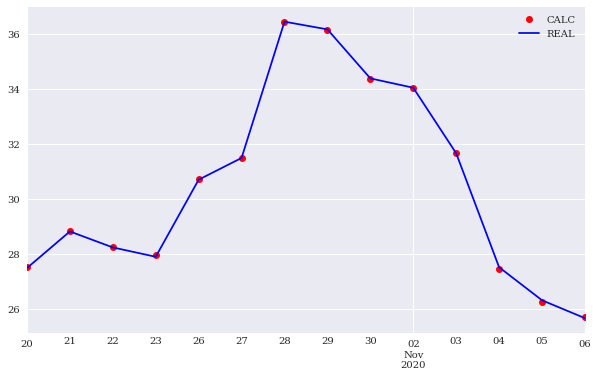

In [37]:
comp[['CALC', 'REAL']].plot(style=['ro', 'b'], figsize=(10, 6));

<p style="font-family: monospace;">Calculated VSTOXX 2M sub-index values vs. real ones.

The following figure shows the point-wise differences between the two time series.

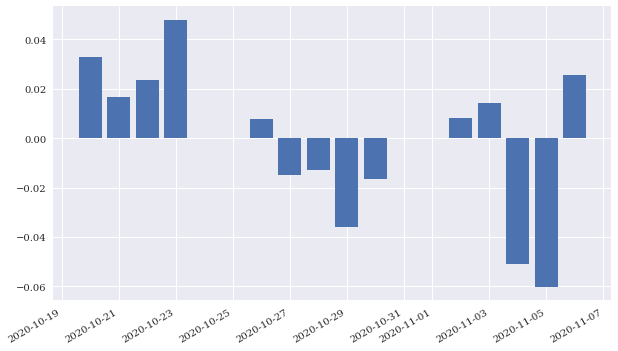

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(comp.index, comp['DIFF'])
plt.gcf().autofmt_xdate();

<p style="font-family: monospace;">Differences of calculated VSTOXX 2M index values and real ones.

## Calculating the VSTOXX Index

If the values for the sub-indexes VSTOXX 1M and VSTOXX 2M, $V_1$ and $V_2$ say, are given, then the value for the VSTOXX index itself, $V$ say, is calculated by the linear interpolation of $V_1$ and $V_2$:

$$
V = \sqrt{\left(T_1\cdot V_1^2\cdot\left(\frac{N_{T_{2}}-N_{30}}{N_{T_{2}}-N_{T_1}}\right)+T_{2}\cdot V_2^2\cdot\left(\frac{N_{30}-N_{T_1}}{N_{T_{2}}-N_{T_{1}}}\right)\right)\cdot\frac{N_{365}}{N_{30}}}
$$

where

* $N_{T_1}=$ time to expiry of $V_1$´s options series in seconds
* $N_{T_2}=$ time to expiry of $V_2$´s options series in seconds
* $N_{30}= 30$ days in seconds
* $N_{365}=$ time for a standard year in seconds
* $T_1= N_{T_1}/N_{365}$
* $T_2= N_{T_2}/N_{365}$

Recall that the sub-index VSTOXX 1M is not defined on the final settlement day of the underlying option series and the day before. For these dates, we use VSTOXX 2M and VSTOXX 3M as $V_1$ and $V_2$, respectively.

The Python module ``index_vstoxx_calculation.py`` (see the appendix for the module in its entirety) implements the VSTOXX index calculation routine &mdash; given the respective sub-index time series data sets. The module starts like usual with some imports.

In [39]:
!sed -n 9,12p scripts/index_vstoxx_calculation.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from index_date_functions import *


The function ``calculate_vstoxx()`` is the core of the module.

In [40]:
import index_vstoxx_calculation as ivc

In [41]:
ivc.calculate_vstoxx??

Signature: ivc.calculate_vstoxx(url)
Source:   
def calculate_vstoxx(url):
    ''' Function to calculate the VSTOXX volatility index given time series
    of the relevant sub-indexes.

    Parameters
    path: string
        string with path of data files

    Returns
    data: pandas DataFrame object
        results of index calculation
    '''
    # constant parameters
    seconds_year = 365 * 24 * 3600.
    seconds_30_days = 30 * 24 * 3600.

    # import historical VSTOXX data
    data = pd.read_csv(url, index_col=0, parse_dates=True)

    # determine the settlement dates for the two underlying option series
    data['Settlement date 1'] = [first_settlement_day(a) for a in data.index]
    data['Settlement date 2'] = [second_settlement_day(a) for a in data.index]

    # deduce the life time (in seconds) from current date to
    # final settlement Date
    data['Life time 1'] = [(data['Settlement date 1'][i] - i).days
                            * 24 * 60 * 60 for i in data.index]
   

As its single argument, the function takes the path to a CSV file containing historical VSTOXX data for the index itself and the sub-indexes. The re-calculation of it then is as straightforward as follows.

In [42]:
import index_vstoxx_calculation as ivc
%time data = ivc.calculate_vstoxx(url)

CPU times: user 246 ms, sys: 3.75 ms, total: 249 ms
Wall time: 444 ms


Let us inspect the pandas ``DataFrame`` with the results.

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1614 entries, 2010-09-15 to 2020-11-06
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   .V2TX              1614 non-null   float64       
 1   .V6I1              1614 non-null   float64       
 2   .V6I2              1614 non-null   float64       
 3   .V6I3              1614 non-null   float64       
 4   .V6I4              1614 non-null   float64       
 5   .V6I5              1614 non-null   float64       
 6   .V6I6              1614 non-null   float64       
 7   .V6I7              1614 non-null   float64       
 8   .V6I8              1614 non-null   float64       
 9   Settlement date 1  1614 non-null   datetime64[ns]
 10  Settlement date 2  1614 non-null   datetime64[ns]
 11  Life time 1        1614 non-null   int64         
 12  Life time 2        1614 non-null   int64         
 13  Use V6I2           1614 non-null   bool      

A brief look at the absolute average error of the re-calculation reveals that the implementation yields quite accurate results.

In [44]:
## output: average error of re-calculation
data['Difference'].mean()

-0.0010495442845352618

The following figure compares the original `.V2TX` time series with the re-calculated values.

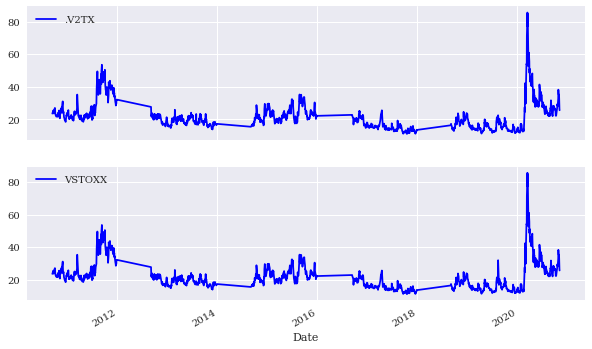

In [45]:
## original vs. re-calculated VSTOXX index
data[['.V2TX', 'VSTOXX']].plot(subplots=True, figsize=(10, 6),
                              style="blue", grid=True);

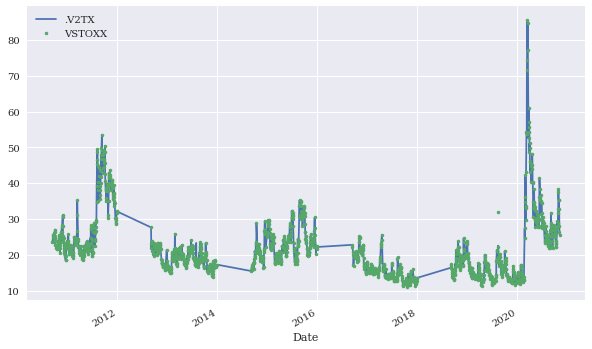

In [46]:
## original vs. re-calculated VSTOXX index
data[['.V2TX', 'VSTOXX']].plot(figsize=(10, 6), style=['-', '.']);

<p style="font-family: monospace;">Historical VSTOXX index values re-calculated vs. real ones.

Finally, the following figure presents the absolute differences. The figure shows that the differences are in general marginal with a few outliers observed here and there.

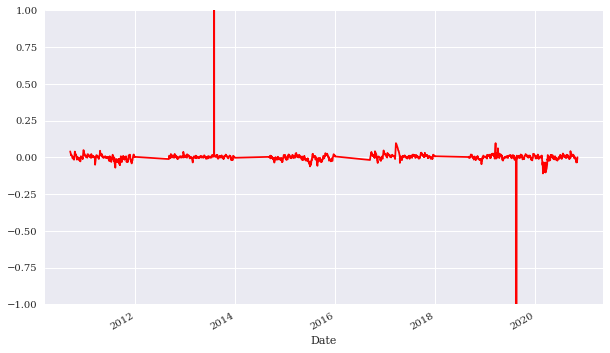

In [47]:
## differences between single values
data['Difference'].plot(figsize=(10, 6), style="r", grid=True,
                        ylim=(-1, 1));

<p style="font-family: monospace;">Differences of historical VSTOXX index values re-calculated vs. real ones.

## Conclusions

This chapter (re-) calculates the  VSTOXX volatility index based on historical sub-index values and based on the volatility index definition as derived in the chapter _Model-Free Replication of Variance_. The chapter also shows how to calculate the sub-index values themselves based on EURO STOXX 50 options data. Python code is provided to automatically collect such data from the Eurex web site.

## Python Scripts

### ``index_collect_option_data.py``

In [48]:
!cat scripts/index_collect_option_data.py

#
# Module to collect option series data
# from the web
# Source: www.eurexchange.com
# Data is needed to calculate the VSTOXX
# and its sub-indexes
#
# (c) Dr. Yves J. Hilpisch
# Listed Volatility and Variance Derivatives
#
import requests
from io import *
import numpy as np
import pandas as pd
import datetime as dt
from bs4 import BeautifulSoup
from index_date_functions import *

#
# The URL template
#
URL = 'https://www.eurex.com/ex-en/data/statistics/market-statistics-online/'
URL += '100!onlineStats?productGroupId=13370&productId=69660&viewType=3&'
URL += 'cp=%s&month=%s&year=%s&busDate=%s'


def collect_option_series(month, year, start):
    ''' Collects daily option data from web source.

    Parameters
    month: int
        maturity month
    year: int
        maturity year
    start: datetime object
        starting date

    Returns
    dataset: pandas DataFrame object
        object containing the collected data
    '''
    end = dt.datetime.today()
    delta = (end - start

### `index_subindex_calculation.py`

In [49]:
!cat scripts/index_subindex_calculation.py

#
# Module with functions to compute VSTOXX sub-indexes
#
# Data as generated by the script index_collect_option_data.py
# is needed for the calculations in this module
#
# (c) Dr. Yves J. Hilpisch
# Listed Volatility and Variance Derivatives
#
import math
import numpy as np
import pandas as pd
import datetime as dt
import index_date_functions as idf
pd.options.mode.chained_assignment = None


def compute_subindex(data, delta_T, R):
    ''' Computes a sub-index for given option series data.

    Parameters
    data: pandas.DataFrame object
        contains the option data
    delta_T: float
        time interval
    R: float
        discount factor

    Returns
    subVSTOXX: float
        sub-index value
    '''
    # difference between put and call option with same strike
    data['Diff_Put_Call'] = np.abs(data.Put_Price - data.Call_Price)
    # converts the strike price which serves as index so far
    # to a regular data column
    data = data.reset_index()
    data['delta_K'] = No

### `index_vstoxx_calculation.py`

In [50]:
!cat scripts/index_vstoxx_calculation.py

#
# Module to compute VSTOXX index values
# given the values for the relevant sub-indexes
# as generated by the module index_subindex_calculation.py
#
# (c) Dr. Yves J. Hilpisch
# Listed Volatility and Variance Derivatives
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from index_date_functions import *


def calculate_vstoxx(url):
    ''' Function to calculate the VSTOXX volatility index given time series
    of the relevant sub-indexes.

    Parameters
    path: string
        string with path of data files

    Returns
    data: pandas DataFrame object
        results of index calculation
    '''
    # constant parameters
    seconds_year = 365 * 24 * 3600.
    seconds_30_days = 30 * 24 * 3600.

    # import historical VSTOXX data
    data = pd.read_csv(url, index_col=0, parse_dates=True)

    # determine the settlement dates for the two underlying option series
    data['Settlement date 1'] = [first_settlement_day(a) for a in data.index]
    data['Settleme

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>